## Problem 7.13

Need to edit question slightly: 

Domain size - $x\in[0, 1]$ 


### Boundary conditions: 

\begin{align*}
\partial_x \theta(x=0, \, t) &= H_0 = 0 \\ 
\theta(x=1, \, t) &= \theta_1 = 1 
\end{align*}




### Initial condition
\begin{equation*}
\theta(x, \, t=0) = \theta_0 = 1 + \cos\left(\frac{\pi x}{2}\right)
\end{equation*}


### Analytical solution 
\begin{equation*}
\theta(x, \, t) = 1 + \exp\left(- \left(\frac{\pi}{2}\right)^2 t\right) \cos\left(\frac{\pi x}{2}\right)
\end{equation*}


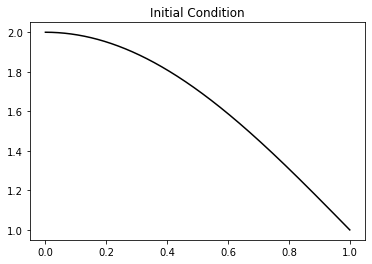

In [7]:
import numpy as np 
import matplotlib.pyplot as plt 


# Initial condition 
fig, ax = plt.subplots()
xplt = np.linspace(0, 1, 1000)
ax.plot(xplt, 1 + np.cos(0.5* np.pi * xplt), 'k');
ax.set_title('Initial Condition');

### Domain setup

In [9]:
L = 1
nelem   = 10        # number of elements, n
npts    = nelem + 1 # n+1

# Global domain node locations
x = np.linspace(0, L, npts)

# Compute Delta x for each element: 
dx = x[1:] - x[:-1]

# Boundary conditions: 
theta_1 = 1
H0      = 0

### K matrix: 

In [3]:
# Generate K & M matrices
K = np.zeros((nelem, nelem))

for ielem in range(nelem):

    if ielem == 0:
        K[ielem, ielem] = 1 / dx[0]
    else:
        K[ielem, ielem] = (1 / dx[ielem - 1]) + (1 / dx[ielem])
        K[ielem - 1, ielem] = -1 / dx[ielem - 1]
        K[ielem, ielem - 1] = -1 / dx[ielem - 1]

### Mass matrix: 

In [4]:
M = np.zeros((nelem, nelem))

for ielem in range(nelem):

    if ielem == 0: 
        # 7.88
        M[ielem, ielem] = dx[0] / 3
    else:
        # 7.90
        M[ielem, ielem] = (dx[ielem - 1] + dx[ielem]) / 3  
        # 7.89
        M[ielem - 1, ielem] = dx[ielem - 1] / 6
        M[ielem, ielem - 1] = dx[ielem - 1] / 6

### Forcing

Force vector is given in Eqn. 7.87 as 
\begin{equation*}
F_A = \int_0^1 N_A \, h \: \mathrm{d}x + N_A(0) H_0 - \theta_1 \int_0^1 \left( \partial_x N_A \right) \left( \partial_x N_{n+1} \right) \mathrm{d} x  \quad. 
\end{equation*}
For our case, $h=0$ and $H_0 = 0$ such that the force is only 

\begin{align*}
F_A  &=  \theta_1 \int_0^1 \left( \partial_x N_A \right) \left( \partial_x N_{n+1} \right) \mathrm{d} x  \quad, \\ 
     &=  \theta_1 \int_{x_x}^{x_{n+1}} \left( \partial_x N_{n} \right) \left( \partial_x N_{n+1} \right) \mathrm{d} x  \quad,\\ 
      &=  \frac{\theta_1}{\Delta_x}
\end{align*}

at the $n$th node only. 

In [8]:
F = np.zeros(nelem)
F[-1] = theta_1/(dx[-1])

### Timestepping 

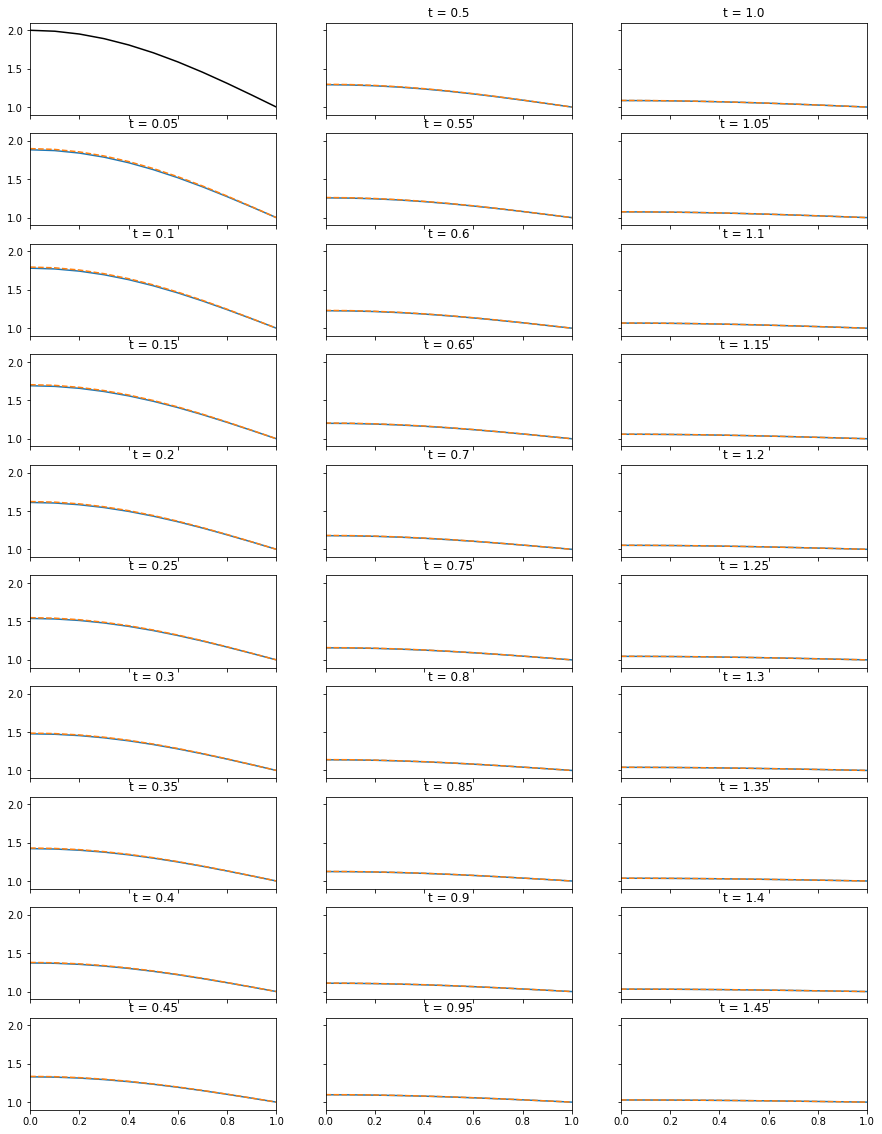

In [12]:
eta = 0.5
dt  = 0.01
nsteps = 150 


temp       = np.zeros(npts)

dtemp_dt   = np.zeros(npts)

# Initial condition 
temp       = 1 + np.cos(0.5* np.pi * x)

dtemp_dt   = (np.pi*np.pi/4)*np.sin(0.5* np.pi * x)

# Inverse of [M + eta \delta t K]
MKinv = np.linalg.inv(M + eta*dt*K)

# Create plots of time evolution
fig, ax = plt.subplots(10, 3,
                       sharey=True, 
                       figsize=(15,20),
                       sharex=True)

# Step in time 
time = 0

# Plot initial condition 
ax[0,0 ].plot(x, temp, 'k')

iax = 1
icol = 0 
for istep in range(1,nsteps):
    # Compute time 
    time += dt

    # --- FEM calculation ---
    # Predictor:
    dtilde = temp[:-1] + (1-eta)* dt * dtemp_dt[:-1]

    # Solve for dtemp_dt at next timestep
    dtemp_dt[:-1] = np.matmul(MKinv, F - np.matmul(K, dtilde))

    # Corrector:
    temp[:-1] = dtilde + (eta * dt * dtemp_dt[:-1])
    
    
    if istep%5 == 0:

        # Compute analytical solution
        analytical =  1 + (np.exp(- 0.25 * time * np.pi**2 ) * np.cos(0.5*np.pi *x))
        ax[iax, icol].plot(x, analytical, '-')
        
        
        # Plot
        ax[iax, icol].set_title(f"t = {np.around(time,2)}");
        ax[iax, icol].plot(x, temp, '--')
        
        iax += 1
        if iax==10: 
            icol += 1
            iax = 0 
        
    
# Some plot formatting 
ax[0,0].set_xlim([0,1]);
ax[0,0].set_ylim([0.9,2.1]);